This is a demo script that trains the unsupervised domain adaptive Y-Net segmentation technique, as proposed in [1], for mitochondria segmentation in electron microscopy data. 

1. Joris Roels, Julian Hennies, Yvan Saeys, Wilfried Philips, Anna Kreshuk, ["Domain adaptive segmentation in volume electron microscopy imaging"](https://arxiv.org/abs/1810.09734), ISBI 2019 (accepted).

Let's start with importing the required packages. 

In [1]:
%matplotlib inline
import numpy as np
import argparse
import datetime
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from data.datasets import UnlabeledVolumeDataset, StronglyLabeledVolumeDataset
from networks.ynet import YNet
from util.losses import CrossEntropyLoss, MSELoss
from util.preprocessing import get_augmenters_2d
from util.validation import segment
from util.metrics import jaccard, dice, accuracy_metrics
from util.io import imwrite3D
from util.tools import overlay

Let's start by loading the data and a quick visualisation! 

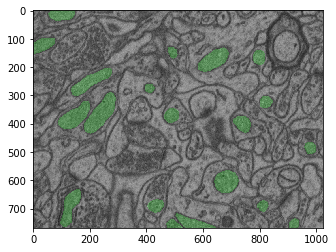

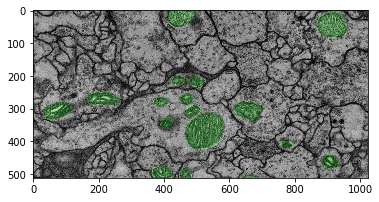

In [2]:
# source data
src_data_train = "../data/EM/EPFL/training.tif"
src_labels_train = "../data/EM/EPFL/training_groundtruth.tif"
src_data_test = "../data/EM/EPFL/testing.tif"
src_labels_test = "../data/EM/EPFL/testing_groundtruth.tif"

# target data
tar_data_train = "../data/EM/VNC/data_larger.tif"
tar_data_test = "../data/EM/VNC/data_test.tif"
tar_labels_test = "../data/EM/VNC/mito_labels_test.tif"

input_shape = (1, 128, 128)

# augmenters
src_train_xtransform, src_train_ytransform, src_test_xtransform, src_test_ytransform = get_augmenters_2d()
tar_train_xtransform, _, tar_test_xtransform, tar_test_ytransform = get_augmenters_2d()

# datasets
src_train = StronglyLabeledVolumeDataset(src_data_train, src_labels_train, input_shape, transform=src_train_xtransform, target_transform=src_train_ytransform, preprocess='unit')
src_test = StronglyLabeledVolumeDataset(src_data_test, src_labels_test, input_shape, transform=src_test_xtransform, target_transform=src_test_ytransform, preprocess='unit')
tar_train = UnlabeledVolumeDataset(tar_data_train, input_shape=input_shape, transform=tar_train_xtransform, preprocess='unit')
tar_test = StronglyLabeledVolumeDataset(tar_data_test, tar_labels_test, input_shape=input_shape, transform=tar_test_xtransform, target_transform=tar_test_ytransform, preprocess='unit')

# show examples
plt.imshow(overlay(src_test.data[0,...],src_test.labels[0,...], alpha=0.2))
plt.show()
plt.imshow(overlay(tar_test.data[0,...],tar_test.labels[0,...], alpha=0.2))
plt.show()

Pretty similar data.. we will use the EPFL dataset as source, and the VNC data as target. Let's put this data in a dataloader for easy use in PyTorch. We will use a batch size of 2 for training and testing. You can make this smaller or larger depending on your computational resources. 

In [3]:
batch_size = 2

src_train_loader = DataLoader(src_train, batch_size=batch_size)
src_test_loader = DataLoader(src_test, batch_size=batch_size)
tar_train_loader = DataLoader(tar_train, batch_size=batch_size)
tar_test_loader = DataLoader(tar_test, batch_size=batch_size)

We are now ready to define and train the network! For computational simplicity, we will use a slightly smaller version of the original U-Net. We will train the network with cross entropy and MSE loss for 10 epochs with learning rate of 0.001 with multiplicative decay (decay factor 0.9) every epoch. We will test the network after every epoch and print out some logging statistics every 50 iterations. The regularization parameter for the reconstruction loss is set to 0.001. 

In [4]:
net = YNet(feature_maps=16)

lambda_rec = 1e-3
lr = 1e-3
step_size = 1
gamma = 0.9
epochs = 10
test_freq = 1
print_stats = 50
log_dir = "logs"

loss_fn_seg = CrossEntropyLoss()
loss_fn_rec = MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

net.train_net(train_loader_source=src_train_loader, train_loader_target=tar_train_loader,
              test_loader_source=src_test_loader, test_loader_target=tar_test_loader,
              lambda_reg=lambda_rec, optimizer=optimizer, loss_seg_fn=loss_fn_seg, loss_rec_fn=loss_fn_rec,
              scheduler=scheduler, epochs=epochs, test_freq=test_freq, print_stats=print_stats,
              log_dir=log_dir)

[2019-02-19 16:34:02.589050] Epoch     0/   10
[2019-02-19 16:34:10.229705] Epoch     0 - Iteration     0/  500 - Loss seg src: 0.614091 - Loss rec src: 0.325768 - Loss rec tar: 0.362764 - Loss: 0.614780
[2019-02-19 16:34:13.960631] Epoch     0 - Iteration    50/  500 - Loss seg src: 0.379866 - Loss rec src: 0.101331 - Loss rec tar: 0.099687 - Loss: 0.380067
[2019-02-19 16:34:17.786245] Epoch     0 - Iteration   100/  500 - Loss seg src: 0.234728 - Loss rec src: 0.032227 - Loss rec tar: 0.065334 - Loss: 0.234825
[2019-02-19 16:34:21.475880] Epoch     0 - Iteration   150/  500 - Loss seg src: 0.153966 - Loss rec src: 0.017647 - Loss rec tar: 0.039053 - Loss: 0.154023
[2019-02-19 16:34:25.500373] Epoch     0 - Iteration   200/  500 - Loss seg src: 0.130934 - Loss rec src: 0.038570 - Loss rec tar: 0.031490 - Loss: 0.131004
[2019-02-19 16:34:29.237912] Epoch     0 - Iteration   250/  500 - Loss seg src: 0.117743 - Loss rec src: 0.013686 - Loss rec tar: 0.043277 - Loss: 0.117800
[2019-02-19

[2019-02-19 16:37:59.161465] Epoch     4 - Iteration   200/  500 - Loss seg src: 0.051983 - Loss rec src: 0.030258 - Loss rec tar: 0.035937 - Loss: 0.052049
[2019-02-19 16:38:02.780026] Epoch     4 - Iteration   250/  500 - Loss seg src: 0.038031 - Loss rec src: 0.029755 - Loss rec tar: 0.054069 - Loss: 0.038115
[2019-02-19 16:38:06.523334] Epoch     4 - Iteration   300/  500 - Loss seg src: 0.134435 - Loss rec src: 0.009162 - Loss rec tar: 0.052554 - Loss: 0.134497
[2019-02-19 16:38:10.033073] Epoch     4 - Iteration   350/  500 - Loss seg src: 0.051880 - Loss rec src: 0.012998 - Loss rec tar: 0.039170 - Loss: 0.051933
[2019-02-19 16:38:13.380060] Epoch     4 - Iteration   400/  500 - Loss seg src: 0.022384 - Loss rec src: 0.017431 - Loss rec tar: 0.046788 - Loss: 0.022448
[2019-02-19 16:38:16.982392] Epoch     4 - Iteration   450/  500 - Loss seg src: 0.110245 - Loss rec src: 0.008770 - Loss rec tar: 0.055008 - Loss: 0.110309
[2019-02-19 16:38:20.661422] Epoch     4 - Loss seg src: 0

[2019-02-19 16:41:48.714082] Epoch     8 - Iteration   400/  500 - Loss seg src: 0.121381 - Loss rec src: 0.017357 - Loss rec tar: 0.053683 - Loss: 0.121452
[2019-02-19 16:41:52.427566] Epoch     8 - Iteration   450/  500 - Loss seg src: 0.103465 - Loss rec src: 0.011653 - Loss rec tar: 0.032706 - Loss: 0.103510
[2019-02-19 16:41:56.296680] Epoch     8 - Loss seg src: 0.025034 - Loss rec src: 0.008677 - Loss rec tar: 0.020863 - Loss: 0.025063
[2019-02-19 16:42:05.081284] Epoch     8 - Loss seg src: 0.054105 - Loss seg tar: 0.080726 - Loss rec src: 0.005914 - Loss rec tar: 0.018359 - Loss: 0.054129
[2019-02-19 16:42:05.223632] Epoch     9/   10
[2019-02-19 16:42:12.234473] Epoch     9 - Iteration     0/  500 - Loss seg src: 0.037443 - Loss rec src: 0.028122 - Loss rec tar: 0.052792 - Loss: 0.037524
[2019-02-19 16:42:16.110091] Epoch     9 - Iteration    50/  500 - Loss seg src: 0.135335 - Loss rec src: 0.043373 - Loss rec tar: 0.029252 - Loss: 0.135407
[2019-02-19 16:42:19.810982] Epoch

Great! We will show reconstruction and segmentation results on the first slice of the target test dataset and validate it! 

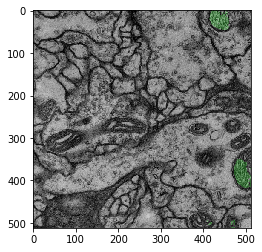

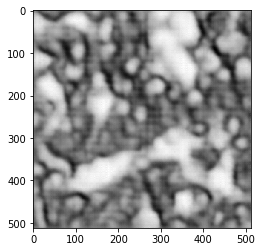

Validation results:
     Jaccard: 0.152278
     Dice: 0.264308
     Accuracy: 0.921787
     Precision: 1.000000
     Recall: 0.152278
     F-score: 0.264308


In [5]:
test_data = tar_test.data[0:1,:512,:512]
test_labels = tar_test.labels[0:1,:512,:512]

test_data_rec, test_data_seg = net(torch.Tensor(test_data[np.newaxis,...]).cuda())
test_data_rec = test_data_rec[0,...].data.cpu().numpy()
test_data_seg = test_data_seg[0,...].data.cpu().numpy()
segmentation = test_data_seg[1, ...]>0.5

plt.imshow(overlay(test_data[0, ...], segmentation, alpha=0.2))
plt.show()
plt.imshow(test_data_rec[0, ...], cmap='gray')
plt.show()

j = jaccard(segmentation, test_labels)
d = dice(segmentation, test_labels)
a, p, r, f = accuracy_metrics(segmentation, test_labels)
print('Validation results:')
print('     Jaccard: %f' % (j))
print('     Dice: %f' % (d))
print('     Accuracy: %f' % (a))
print('     Precision: %f' % (p))
print('     Recall: %f' % (r))
print('     F-score: %f' % (f))

Of course the results can be improved significantly by increasing the capacity of the network and tuning the hyperparameters. 